In [ ]:
from google.colab import files

uploaded3 = files.upload()

for fn in uploaded3.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded3[fn])))

Saving stock_market.csv to stock_market (2).csv
User uploaded file "stock_market.csv" with length 588217 bytes


In [ ]:
import pandas as pd
bpcl = pd.read_csv('stock_market.csv')
print(bpcl.head(3))

         Time  Prev Close    Open  ...  Deliverable Volume  %Deliverble      Time.1
0  2000-01-03      381.20  405.00  ...            443175.0      0.44345  2000-01-03
1  2000-01-04      399.25  397.75  ...            443175.0      0.44345  2000-01-04
2  2000-01-05      370.50  350.00  ...            443175.0      0.44345  2000-01-05

[3 rows x 13 columns]


In [ ]:
bpcl.index = bpcl['Time']
print(bpcl.head(3))
data = bpcl.drop(['Time.1'], axis = 1)
bpcl = data.drop(['Time'], axis = 1)
print(bpcl.head(3))

                  Time  Prev Close  ...  %Deliverble      Time.1
Time                                ...                         
2000-01-03  2000-01-03      381.20  ...      0.44345  2000-01-03
2000-01-04  2000-01-04      399.25  ...      0.44345  2000-01-04
2000-01-05  2000-01-05      370.50  ...      0.44345  2000-01-05

[3 rows x 13 columns]
            Prev Close    Open  ...  Deliverable Volume  %Deliverble
Time                            ...                                 
2000-01-03      381.20  405.00  ...            443175.0      0.44345
2000-01-04      399.25  397.75  ...            443175.0      0.44345
2000-01-05      370.50  350.00  ...            443175.0      0.44345

[3 rows x 11 columns]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RNN
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

bpcl.head(3)

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Deliverable Volume,%Deliverble
Time,,,,,,,,,,,
2000-01-03,381.20,405.00,407.00,393.05,397.75,399.25,399.32,8720,3.482029e+11,443175.0,0.44345
2000-01-04,399.25,397.75,397.75,367.40,377.45,370.50,375.71,22820,8.573699e+11,443175.0,0.44345
2000-01-05,370.50,350.00,385.00,350.00,360.10,359.95,359.96,152538,5.490785e+12,443175.0,0.44345


In [ ]:
bpcl=bpcl.reset_index()
bpcl.head(3)

,index,Time,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Deliverable Volume,%Deliverble
0,0,2000-01-03,381.20,405.00,407.00,393.05,397.75,399.25,399.32,8720,3.482029e+11,443175.0,0.44345
1,1,2000-01-04,399.25,397.75,397.75,367.40,377.45,370.50,375.71,22820,8.573699e+11,443175.0,0.44345
2,2,2000-01-05,370.50,350.00,385.00,350.00,360.10,359.95,359.96,152538,5.490785e+12,443175.0,0.44345


In [ ]:
import numpy as np
lag_features = ["High", "Low", "Volume", "Turnover","Close"]
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = bpcl[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = bpcl[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = bpcl[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    bpcl[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    bpcl[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    bpcl[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    
    bpcl[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    bpcl[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    bpcl[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

bpcl.fillna(bpcl.mean(), inplace=True)


bpcl.set_index("Time", drop=False, inplace=True)

In [ ]:
bpcl.Time = pd.to_datetime(bpcl.Time, format="%Y-%m-%d")
bpcl["month"] = bpcl.Time.dt.month
bpcl["week"] = bpcl.Time.dt.isocalendar().week
bpcl["day"] = bpcl.Time.dt.day
bpcl["day_of_week"] = bpcl.Time.dt.dayofweek
bpcl.head(3)

,index,Time,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Deliverable Volume,%Deliverble,High_mean_lag3,High_mean_lag7,High_mean_lag30,High_std_lag3,High_std_lag7,High_std_lag30,Low_mean_lag3,Low_mean_lag7,Low_mean_lag30,Low_std_lag3,Low_std_lag7,Low_std_lag30,Volume_mean_lag3,Volume_mean_lag7,Volume_mean_lag30,Volume_std_lag3,Volume_std_lag7,Volume_std_lag30,Turnover_mean_lag3,Turnover_mean_lag7,Turnover_mean_lag30,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Close_mean_lag3,Close_mean_lag7,Close_mean_lag30,Close_std_lag3,Close_std_lag7,Close_std_lag30,month,week,day,day_of_week
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0,2000-01-03,381.20,405.00,407.00,393.05,397.75,399.25,399.32,8720,3.482029e+11,443175.0,0.44345,452.935638,452.924652,452.844543,7.142901,11.333698,23.956656,436.628662,436.612732,436.514801,6.871397,10.917168,23.236280,2089415.125,2085886.125,2069983.875,842471.312500,1.040004e+06,1.366095e+06,9.305887e+13,9.291037e+13,9.224002e+13,3.750171e+13,4.640861e+13,6.119838e+13,444.377808,444.362946,444.269897,7.224701,11.149131,23.483959,1,1,3,0
2000-01-04,1,2000-01-04,399.25,397.75,397.75,367.40,377.45,370.50,375.71,22820,8.573699e+11,443175.0,0.44345,407.000000,407.000000,407.000000,7.142901,11.333698,23.956656,393.049988,393.049988,393.049988,6.871397,10.917168,23.236280,8720.000,8720.000,8720.000,842471.312500,1.040004e+06,1.366095e+06,3.482029e+11,3.482029e+11,3.482029e+11,3.750171e+13,4.640861e+13,6.119838e+13,399.250000,399.250000,399.250000,7.224701,11.149131,23.483959,1,1,4,1
2000-01-05,2,2000-01-05,370.50,350.00,385.00,350.00,360.10,359.95,359.96,152538,5.490785e+12,443175.0,0.44345,402.375000,402.375000,402.375000,6.540738,6.540738,6.540738,380.225006,380.225006,380.225006,18.137289,18.137289,18.137289,15770.000,15770.000,15770.000,9970.206055,9.970206e+03,9.970206e+03,6.027864e+11,6.027864e+11,6.027864e+11,3.600355e+11,3.600355e+11,3.600355e+11,384.875000,384.875000,384.875000,20.329321,20.329321,20.329321,1,1,5,2


In [ ]:
df_train = bpcl[bpcl.Time < "2019"]
df_valid = bpcl[bpcl.Time >= "2019"]

exogenous_features = ["High_mean_lag3", "High_std_lag3", "Low_mean_lag3", "Low_std_lag3",
                      "Volume_mean_lag3", "Volume_std_lag3", "Turnover_mean_lag3",
                      "Turnover_std_lag3","High_mean_lag7", "High_std_lag7", "Low_mean_lag7", "Low_std_lag7",
                      "Volume_mean_lag7", "Volume_std_lag7", "Turnover_mean_lag7",
                      "Turnover_std_lag7","High_mean_lag30", "High_std_lag30", "Low_mean_lag30", "Low_std_lag30",
                      "Volume_mean_lag30", "Volume_std_lag30", "Turnover_mean_lag30",
                      "Close_mean_lag3", "Close_mean_lag7","Close_mean_lag30","Close_std_lag3","Close_std_lag7","Close_std_lag30",
                      "Turnover_std_lag30","month","week","day","day_of_week"]

In [ ]:
df_valid['Time'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     577
unique                    577
top       2020-04-13 00:00:00
freq                        1
first     2019-01-01 00:00:00
last      2021-04-30 00:00:00
Name: Time, dtype: object

In [ ]:
dataset = bpcl[exogenous_features].values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
X_train = train[:,1:]
y_train = train[:,0]
X_test = test[:,1:]
y_test = test[:,0]

In [ ]:
batch_size = 1
timesteps = 1
units = 100
nb_epoch = 70

In [ ]:
X_train = X_train.reshape(X_train.shape[0],timesteps,X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0],timesteps,X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 100)                  53600     
_________________________________________________________________
dense (Dense)                (1, 1)                    101       
Total params: 53,701
Trainable params: 53,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
yhat = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat)
print('rmse:{} MAE:{}'.format(rmse,mae))

rmse:0.05356131216696749 MAE:0.03384431079030037


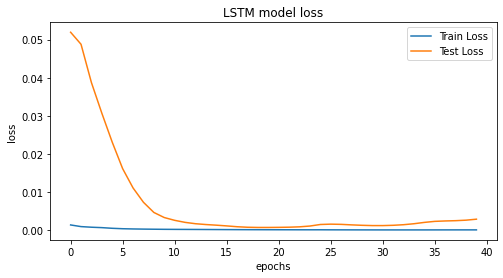

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();


The number of epochs is a hyperparameter of stochastic gradient descent that controls the number of complete passes through the training dataset. 

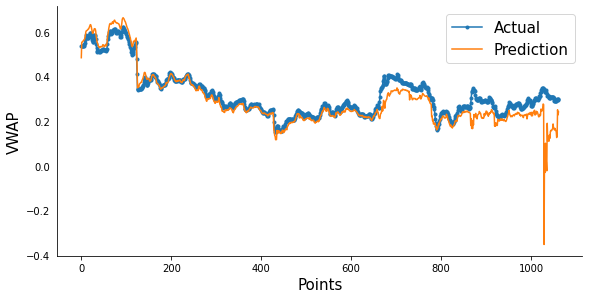

In [ ]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="Actual")
plt.plot(yhat, label="Prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('VWAP', size=15)
plt.xlabel('Points', size=15)
plt.legend(fontsize=15)
plt.show();

RNN model

In [ ]:
model = Sequential()
model.add(SimpleRNN(units,batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(X_train, y_train,epochs=nb_epoch,batch_size=batch_size, validation_data=(X_test, y_test),callbacks=[EarlyStopping(monitor='val_loss', patience=21)],verbose=0,shuffle=False)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, 100)                  13400     
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    101       
Total params: 13,501
Trainable params: 13,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
yhat2 = model.predict(X_test, batch_size=batch_size)
rmse = sqrt(mean_squared_error(y_test, yhat))
mae=mean_absolute_error(y_test, yhat2)
print('rmse:{} MAE:{}'.format(rmse,mae))


rmse:0.05356131216696749 MAE:0.20264458656311035


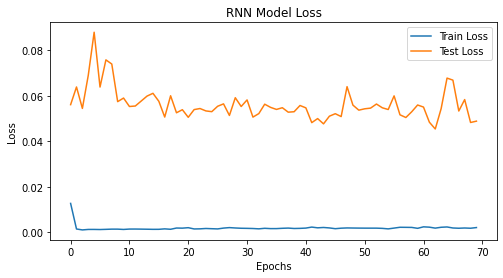

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.show();


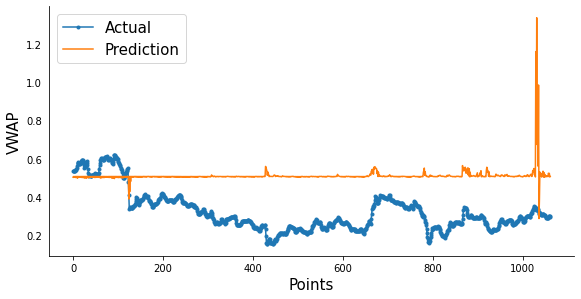

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, marker='.', label="Actual")
plt.plot(yhat2, label="Prediction")
plt.tick_params(left=False, labelleft=True)
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('VWAP', size=15)
plt.xlabel('Points', size=15)
plt.legend(fontsize=15)
plt.show();
